In [1]:
from gelos.config import RAW_DATA_DIR, PROJ_ROOT, PROCESSED_DATA_DIR, DATA_VERSION, REPORTS_DIR, FIGURES_DIR
import geopandas as gpd
import yaml

2025-12-04 21:15:51.203 | INFO     | gelos.config:<module>:16 - PROJ_ROOT path is: /app


In [ ]:

output_dir = PROCESSED_DATA_DIR / DATA_VERSION
data_root = RAW_DATA_DIR / DATA_VERSION
chip_gdf = gpd.read_file(output_dir / 'gelos_chip_tracker_with_tsne.geojson')
reports_dir = REPORTS_DIR / DATA_VERSION
reports_dir.mkdir(exist_ok=True, parents=True)
figures_dir = FIGURES_DIR / DATA_VERSION
figures_dir.mkdir(exist_ok=True, parents=True)

yaml_config_directory = PROJ_ROOT / 'gelos' / 'configs'
for yaml_filepath in yaml_config_directory.glob("*.yaml"):
    with open(yaml_filepath, "r") as f:
        yaml_config = yaml.safe_load(f)
    print(yaml.dump(yaml_config))
    model_name = yaml_config['model']['init_args']['model']
    model_title = yaml_config['model']['title']
    embedding_extraction_strategies = yaml_config['embedding_extraction_strategies']

    # add variables to yaml config so it can be passed to classes
    yaml_config['data']['init_args']['data_root'] = data_root
    yaml_config['model']['init_args']['output_dir'] = output_dir
    embeddings_directories = [item for item in output_dir.iterdir() if item.is_dir()]


data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      DEM:
      - DEM
      S1RTC:
      - VV
      - VH
      S2L2A:
      - COASTAL_AEROSOL
      - BLUE
      - GREEN
      - RED
      - RED_EDGE_1
      - RED_EDGE_2
      - RED_EDGE_3
      - NIR_BROAD
      - NIR_NARROW
      - WATER_VAPOR
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 0
    repeat_bands:
      DEM: 4
    target_size: 96
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 1
    step: 1
    stop: 2
  All Steps of Middle Patch:
  - start: 0
    step: 1
    stop: null
  - start: 18
    step: 1
    stop: 19
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: false
    layers:
    - -1
    model: terramind_v1_base
    model_args:
      merge_method: mean
      modalities:
      - S2L2A
      - S1RTC
      - DEM
      pretrained: true
    output_format

In [25]:

for embeddings_directory in embeddings_directories:

    embedding_layer = embeddings_directory.stem

    for extraction_strategy, slice_args in embedding_extraction_strategies.items():
        print(extraction_strategy, model_title)
        reducer = "tsne"
        break


CLS Token Prithvi EO V2 300M
CLS Token Prithvi EO V2 300M


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
chip_gdf.columns

Index(['category', 'sentinel_1_dates', 'sentinel_2_dates', 'landsat_dates',
       'id', 'lat', 'lon', 'color', 'landsat_thumbs', 'sentinel_1_thumbs',
       'sentinel_2_thumbs', 'terramindv1base_allstepsofmiddlepatch_tsne_x',
       'terramindv1base_allstepsofmiddlepatch_tsne_y',
       'terramindv1base_allpatchesfromapriltojune_tsne_x',
       'terramindv1base_allpatchesfromapriltojune_tsne_y',
       'prithvieov2300m_allpatchesfromapriltojune_tsne_x',
       'prithvieov2300m_allpatchesfromapriltojune_tsne_y',
       'prithvieov2300m_allstepsofmiddlepatch_tsne_x',
       'prithvieov2300m_allstepsofmiddlepatch_tsne_y',
       'prithvieov2300m_clstoken_tsne_x', 'prithvieov2300m_clstoken_tsne_y',
       'geometry'],
      dtype='object')

In [7]:
model_lower = model_title.replace(" ", "").lower()
strategy_lower = extraction_strategy.replace(" ", "").lower()
X = chip_gdf[[
    f"{model_lower}_{strategy_lower}_tsne_x",
    f"{model_lower}_{strategy_lower}_tsne_y"
    ]]
y = chip_gdf["category"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
print(f"Accuracy: {accuracy:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)

Accuracy: 0.9048


Text(0.5, 1.0, 'Random Forest Classifier using Prithvi EO V2 300M\ntsne of CLS Token')

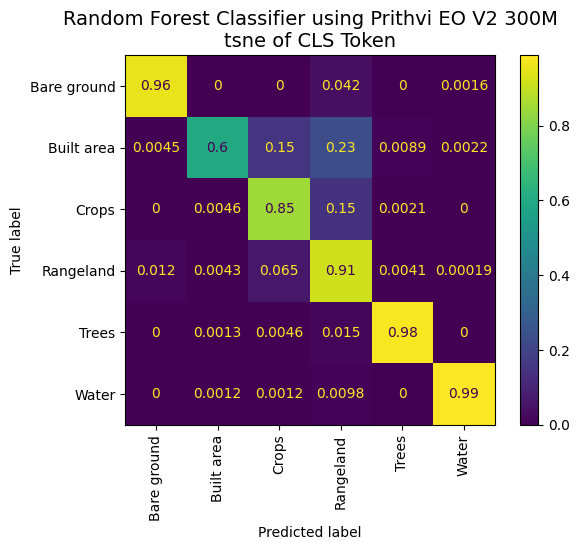

In [34]:
disp.plot(xticks_rotation="vertical")
disp.ax_.set_title(f"Random Forest Classifier using {model_title}\n{reducer} of {extraction_strategy}", fontsize=14)